In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
color_pal = sns.color_palette()

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [25]:
df = pd.read_csv('./archive/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [26]:
# Set time series as index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index) # cast index from object to index
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


<AxesSubplot: title={'center': 'PJME Energy Use in MW '}, xlabel='Datetime'>

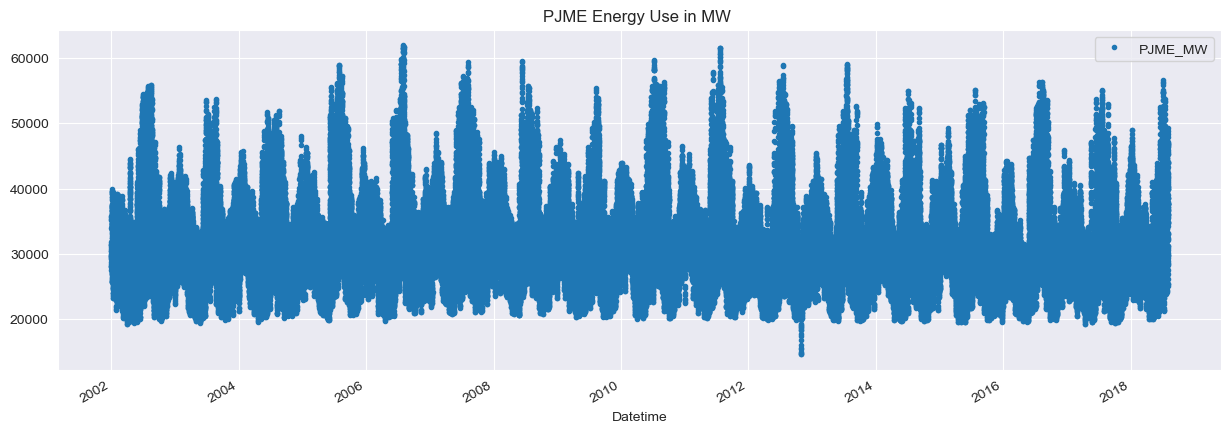

In [27]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW ')

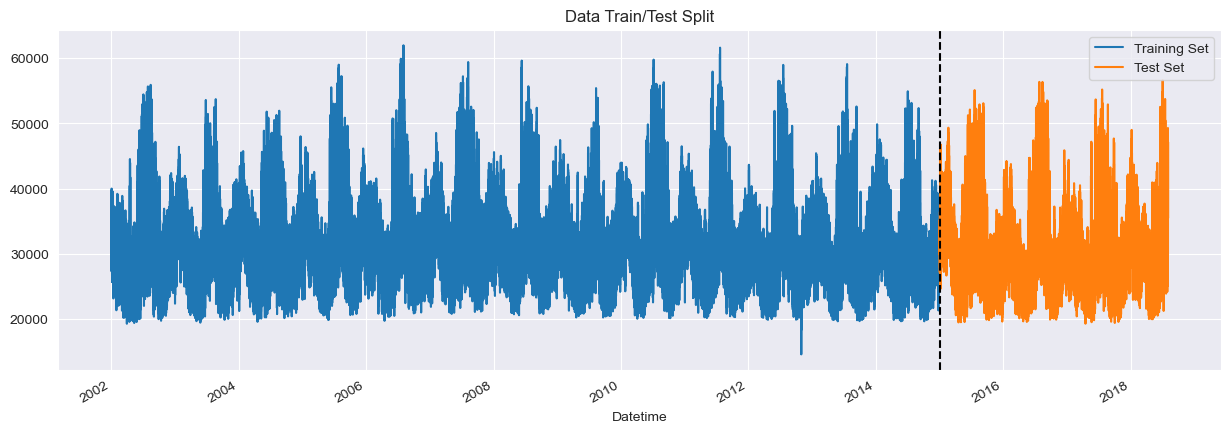

In [28]:
#train test split
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

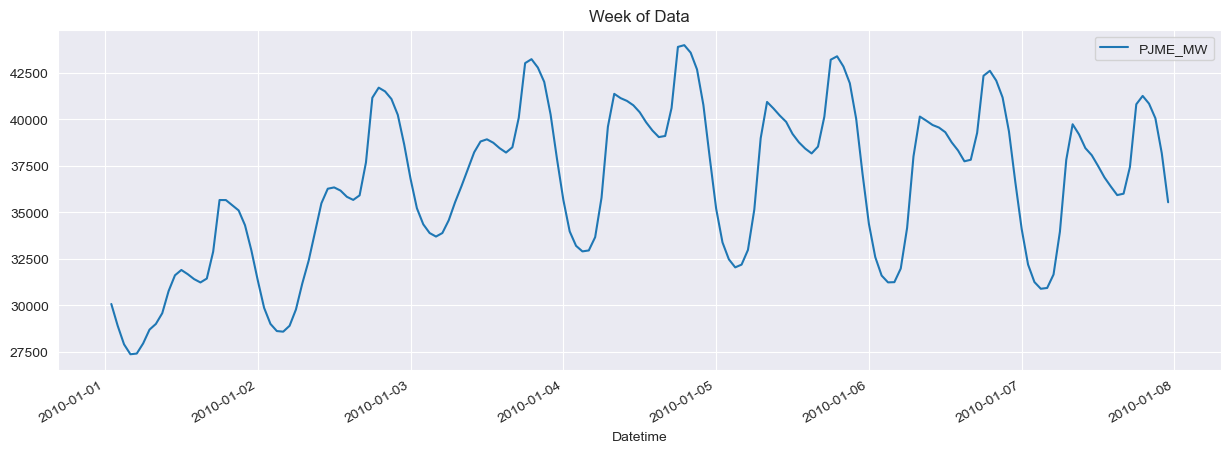

In [29]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]\
        .plot(figsize=(15, 5), title='Week of Data')
plt.show()

In [30]:
# Feature Creation
def create_features(df):
        """
        Create time series features based on time series index.
        """
        df = df.copy()
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['year'] = df.index.year
        df['day_of_year'] = df.index.dayofyear
        return df

In [31]:
df = create_features(df)

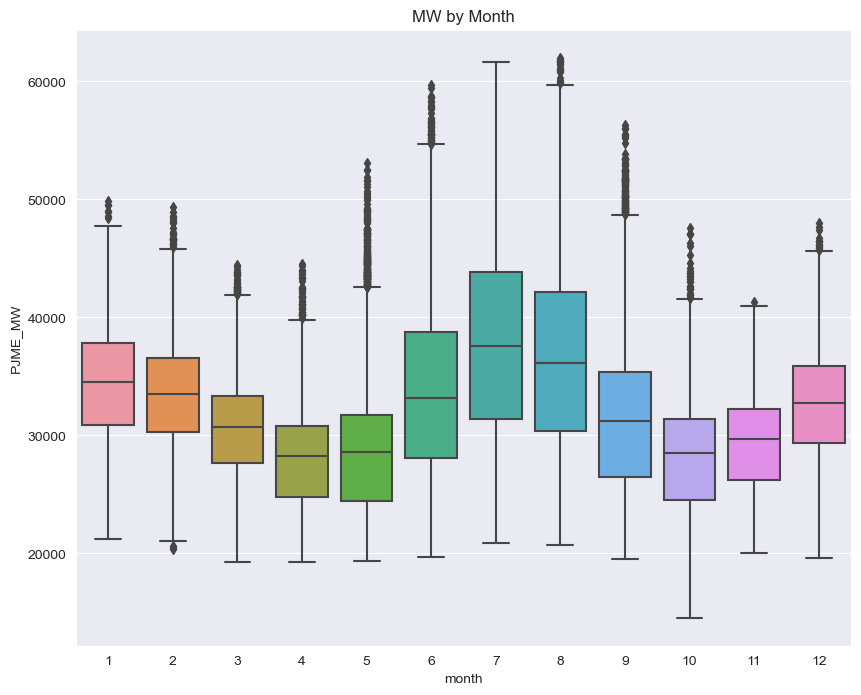

In [32]:
# Visualize our Feature / Target Relationship

# show the distribution
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')
plt.show()

In [33]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'day_of_year']
TARGET = 'PJME_MW'

In [34]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [35]:
# Create the model
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [36]:
# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi

,importance
hour,0.448804
dayofweek,0.158668
quarter,0.033319
month,0.228156
year,0.022634
day_of_year,0.108419


<AxesSubplot: title={'center': 'Feature Importance'}>

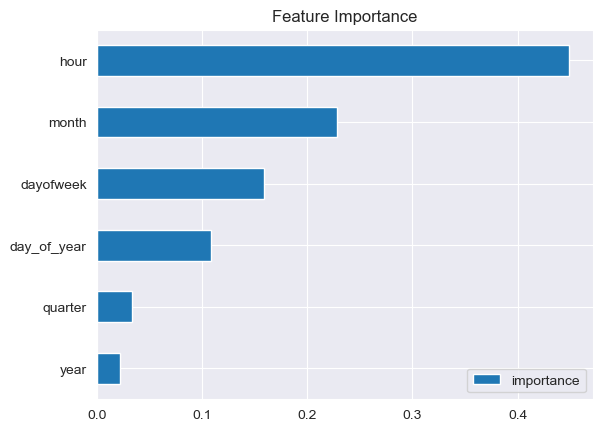

In [37]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

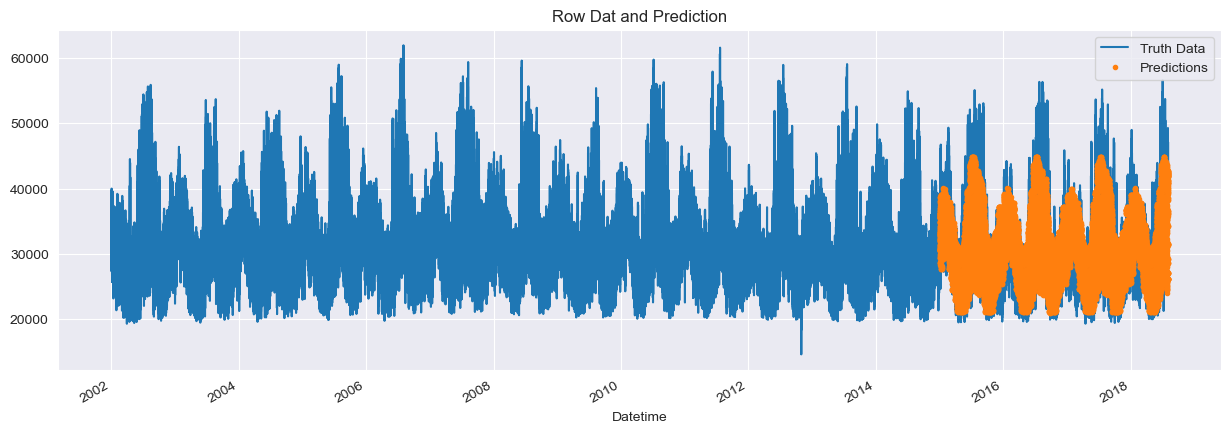

In [39]:
# Forecast on Test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style=".")
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Row Dat and Prediction')
plt.show()

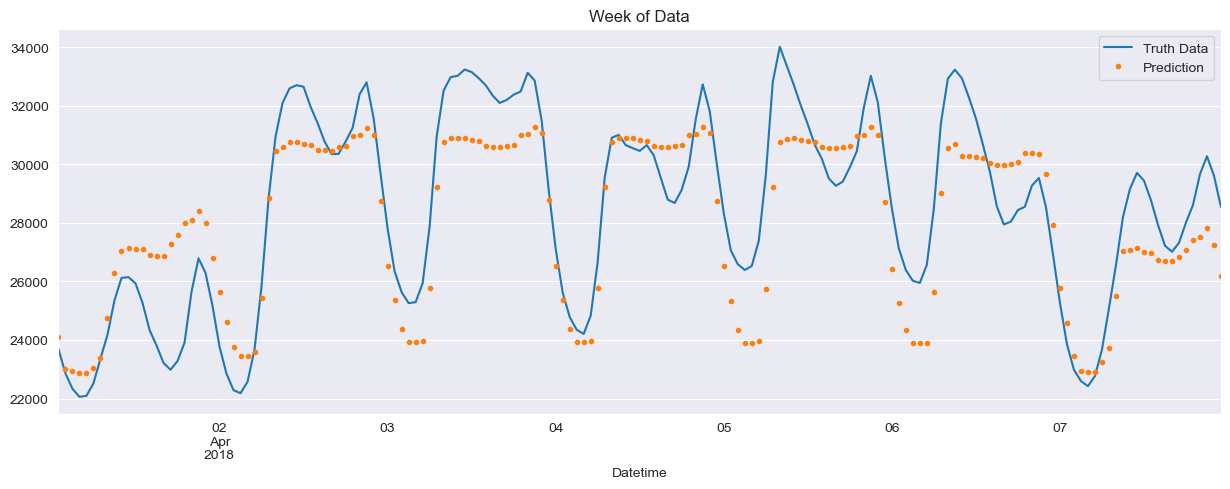

In [40]:
ax = df.iloc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
        .plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
        .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [42]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


In [47]:
# Calculate Error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64